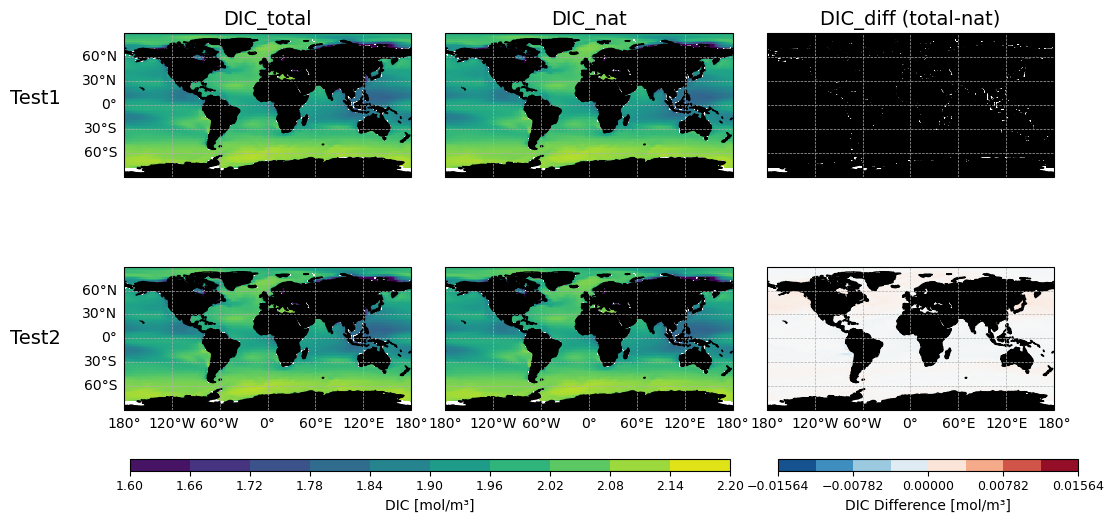

In [70]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# path
file_path1 = '/work/uo1451/m301158/MPI-ESM/data/test_pictrl003/'
file_path2 = '/work/uo1451/m301158/MPI-ESM/data/test_pictrl_ver2_001/'

# data
ds1 = nc.Dataset(file_path1 + 'dissic_nat_r192x96_185001-190012.nc')
dic_test1 = ds1.variables['dissic'][:]
dic_nat_test1 = ds1.variables['dissicnat'][:]
lon = ds1.variables['lon'][:]
lat = ds1.variables['lat'][:]

ds2 = nc.Dataset(file_path2 + 'dissic_nat_r192x96_185001-190012.nc')
dic_test2 = ds2.variables['dissic'][:]
dic_nat_test2 = ds2.variables['dissicnat'][:]

# time averaging
dic_test1_clim = np.mean(dic_test1, axis=0)
dic_test2_clim = np.mean(dic_test2, axis=0)
dic_nat_test1_clim = np.mean(dic_nat_test1, axis=0)
dic_nat_test2_clim = np.mean(dic_nat_test2, axis=0)

# DIC_diff 계산
dic_diff_test1 = dic_test1_clim - dic_nat_test1_clim
dic_diff_test2 = dic_test2_clim - dic_nat_test2_clim

# ✅ DIC_diff 컬러바 범위 자동 조정
max_abs_diff1 = max(abs(np.nanmin(dic_diff_test1)), abs(np.nanmax(dic_diff_test1)))
max_abs_diff2 = max(abs(np.nanmin(dic_diff_test2)), abs(np.nanmax(dic_diff_test2)))

# ✅ Test1의 DIC_diff 값이 모두 0이면 강제 흰색, 아니면 RdBu_r 사용
if max_abs_diff1 == 0:
    cmap1 = 'gray'  # 무조건 흰색
    vmin1, vmax1 = None, None  # 컬러바 범위 강제 비활성화
else:
    cmap1 = 'RdBu_r'
    vmin1, vmax1 = -max_abs_diff1, max_abs_diff1  # 중앙이 0이 되도록 설정

# ✅ Test2의 DIC_diff는 무조건 RdBu_r로 설정
cmap2 = 'RdBu_r'
vmin2, vmax2 = -max_abs_diff2, max_abs_diff2  # 중앙이 0이 되도록 설정

# ✅ DIC_total과 DIC_nat의 vmin, vmax 설정 (범위를 1.6 ~ 2.2로 변경)
vmin_dic = 1.6
vmax_dic = 2.2

# Depth
d_idx = 0

# Subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# 변수 리스트
data_list = [dic_test1_clim, dic_nat_test1_clim, dic_diff_test1,
             dic_test2_clim, dic_nat_test2_clim, dic_diff_test2]
titles = ['DIC_total', 'DIC_nat', 'DIC_diff (total-nat)', '', '', '']
cmaps = ['viridis', 'viridis', cmap1, 'viridis', 'viridis', cmap2]

# 컬러바 저장을 위한 리스트
pcm_list = []

# 그래프 그리기
for i in range(2):
    for j in range(3):
        idx = i * 3 + j  # 데이터 리스트 인덱스
        ax = axes[i, j]  # 서브플롯
        data = data_list[idx][d_idx, :, :]  # 특정 depth 선택
        cmap = cmaps[idx]

        # ✅ DIC_total과 DIC_nat의 경우 vmin, vmax를 설정
        if j < 2:
            pcm = ax.pcolormesh(lon, lat, data, cmap=cmap, transform=ccrs.PlateCarree(),
                                vmin=vmin_dic, vmax=vmax_dic)
        else:
            pcm = ax.pcolormesh(lon, lat, data, cmap=cmap, transform=ccrs.PlateCarree(),
                                vmin=vmin1 if i == 0 else vmin2, 
                                vmax=vmax1 if i == 0 else vmax2)

        pcm_list.append(pcm)  # 컬러바 설정을 위해 저장

        # 지도 요소 추가
        ax.coastlines()
        ax.add_feature(cfeature.LAND, color='black')

        # 격자 라벨 설정 (위쪽 & 오른쪽 라벨 제거)
        gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5)
        gl.top_labels = False  # 위쪽 경도 레이블 제거
        gl.right_labels = False  # 오른쪽 위도 레이블 제거
        gl.bottom_labels = i == 1 
        gl.left_labels = j == 0  

        # 개별 제목 설정 (Test2에 대한 제목 제거)
        if titles[idx]:  
            ax.set_title(titles[idx],fontsize=14)

# ✅ Test1 / Test2 제목을 왼쪽에 전체 제목으로 추가
fig.text(0.03, 0.7, "Test1", fontsize=14, ha="left", va="center", rotation=0)
fig.text(0.03, 0.30, "Test2", fontsize=14, ha="left", va="center", rotation=0)

# ✅ 컬러바 설정 (눈금 세분화)
levels1 = np.linspace(vmin_dic, vmax_dic, 11)
levels2 = np.linspace(vmin2, vmax2, 9)  # ✅ 0을 중앙으로 맞추도록 9개로 설정

cbar_ax1 = fig.add_axes([0.13, 0.08, 0.5, 0.02])  
cbar_ax2 = fig.add_axes([0.67, 0.08, 0.25, 0.02])  

# ✅ 컬러바 1 (DIC)
cbar1 = fig.colorbar(
    plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin_dic, vmax=vmax_dic)),
    cax=cbar_ax1, orientation='horizontal', label='DIC [mol/m³]', 
    ticks=levels1, boundaries=levels1
)

# ✅ 컬러바 2 (DIC Difference)
cbar2 = fig.colorbar(
    plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=vmin2, vmax=vmax2)),
    cax=cbar_ax2, orientation='horizontal', label='DIC Difference [mol/m³]', 
    ticks=levels2, boundaries=levels2
)

# 컬러바 1 (DIC) 눈금 조정
cbar1.set_ticks(levels1)  # 겹치지 않게 간격을 두고 표시
cbar1.ax.tick_params(labelsize=9)  # 폰트 크기 축소

# 컬러바 2 (DIC Difference) 눈금 조정
cbar2.set_ticks(levels2[::2])  # 겹치지 않게 간격을 두고 표시
cbar2.ax.tick_params(labelsize=9)  # 폰트 크기 축소

# 서브플롯 간격 조정
plt.subplots_adjust(hspace=0.02, wspace=0.12)
plt.show()
